# Notebook for exploring the experiment without heavy compute or memory required

In [1]:
!date

this notebook is modified from the [Scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) on processing and clustering

#### if running on Colab uncomment and do install below

In [2]:
# !pip install --quiet anndata
# !pip install --quiet scanpy[leiden]
# !pip install --quiet git+https://github.com/ImXman/MACA.git
# !pip install --quiet git+https://github.com/yoseflab/scvi-tools.git

#### import libraries and set notebook variables

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

%matplotlib inline

In [4]:
# naming
cohort = 'lrrk2_crispr'
maca_db = 'bakken'

# directories
wrk_dir = '/labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x'

# in files
raw_anndata_file = f'{wrk_dir}/{cohort}.merged.raw.h5ad'
cell_labels = f'{wrk_dir}/{cohort}.maca.{maca_db}.labels.csv'

# out files
results_file = f'{wrk_dir}/{cohort}.scanpy.h5ad'
results_light_file = f'{wrk_dir}/{cohort}.scanpy_light.h5ad'

# variables
debug = True

### Load the data and cell-type labels (from previous cell assignment)

In [5]:
%%time
adata = sc.read(raw_anndata_file)
cell_labels_df = pd.read_csv(cell_labels, index_col=0)

if debug:
    print(adata)
    print(cell_labels_df.shape)
    display(cell_labels_df.head())

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].
AnnData object with n_obs × n_vars = 105683 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target'
    var: 'gene_ids', 'feature_types', 'genome'
(94109, 14)


,expr_name,num_features,feature_call,num_umis,target,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,Label1,louvain,Mapped,celltype
AAACCCAAGACTACGG-1,ci1-gex-fb,NaN,NaN,NaN,NaN,2208,2208,7911.0,534.0,6.750095,6,17,0,Micro-PVM
AAACCCAAGCACTAAA-1,ci1-gex-fb,3.0,sgPeak38437_29|sgPeak38441_134|sgPeak38441_319,314|13|230,mixed,4996,4996,27407.0,1479.0,5.396432,6,0,0,Micro-PVM
AAACCCAAGCCGGAAT-1,ci1-gex-fb,4.0,sgPeak38441_211|sgPeak38441_310|sgPeak38441_33...,136|5|69|25,sgPeak38441,4591,4591,26085.0,1379.0,5.286563,6,0,0,Micro-PVM
AAACCCAAGGCTCAAG-1,ci1-gex-fb,2.0,sgPeak38441_04|sgPeak38441_266,13|31,sgPeak38441,5753,5753,34377.0,2620.0,7.621375,6,18,0,Micro-PVM
AAACCCAAGTTTGCTG-1,ci1-gex-fb,4.0,sgNT_24|sgNT_49|sgPeak38433_38|sgPeak38441_196,4|9|14|16,mixed,3745,3745,14111.0,939.0,6.654383,6,2,0,Micro-PVM


CPU times: user 687 ms, sys: 1.36 s, total: 2.05 s
Wall time: 41.5 s


#### add the cell-type labels to the obs data

In [6]:
old_order = adata.obs.index.copy()

In [7]:
adata.obs = adata.obs.merge(cell_labels_df['celltype'], how='left', 
                          left_index=True, right_index=True)
if debug:
    display(adata.obs.head())

,expr_name,num_features,feature_call,num_umis,target,celltype
AAACCCAAGACTACGG-1,ci1-gex-fb,NaN,NaN,NaN,NaN,Micro-PVM
AAACCCAAGCACTAAA-1,ci1-gex-fb,3.0,sgPeak38437_29|sgPeak38441_134|sgPeak38441_319,314|13|230,mixed,Micro-PVM
AAACCCAAGCCGGAAT-1,ci1-gex-fb,4.0,sgPeak38441_211|sgPeak38441_310|sgPeak38441_33...,136|5|69|25,sgPeak38441,Micro-PVM
AAACCCAAGGCTCAAG-1,ci1-gex-fb,2.0,sgPeak38441_04|sgPeak38441_266,13|31,sgPeak38441,Micro-PVM
AAACCCAAGTTTGCTG-1,ci1-gex-fb,4.0,sgNT_24|sgNT_49|sgPeak38433_38|sgPeak38441_196,4|9|14|16,mixed,Micro-PVM


In [8]:
adata.obs.index.equals(old_order)

True

#### do basic prep and filtering

In [9]:
%%time

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
# With pp.calculate_qc_metrics, we can compute many metrics very efficiently.
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, 
                           log1p=False, inplace=True)
adata = adata[adata.obs.pct_counts_mt < 10, :]
# Basic filtering:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_genes=3)
# Total-count normalize (library-size correct) the data matrix 𝐗 to \
# 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=10e4)
# Logarithmize the data:
sc.pp.log1p(adata)
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

print(adata)

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 94109 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
CPU times: user 18.6 s, sys: 2.13 s, total: 20.7 s
Wall time: 20.7 s


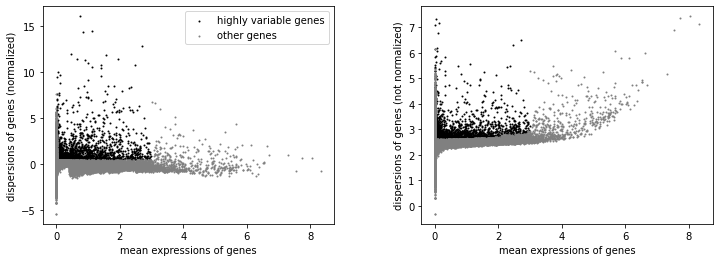

In [10]:
sc.pl.highly_variable_genes(adata)

In [11]:
adata.raw = adata

#### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

May not be able to run this on free Colab
I'm not doing this here, will include later in indivual models

In [12]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

/home/gibbsr/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


#### Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [13]:
sc.pp.scale(adata, max_value=10)

### Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [14]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

#### Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function 

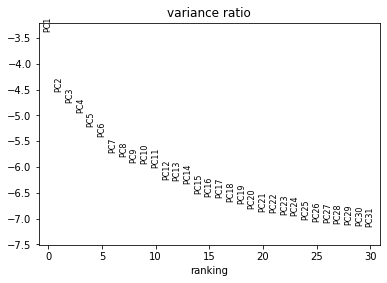

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

### Computing the neighborhood graph
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

2022-02-02 16:03:30.769843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [17]:
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

In [18]:
sc.tl.umap(adata)

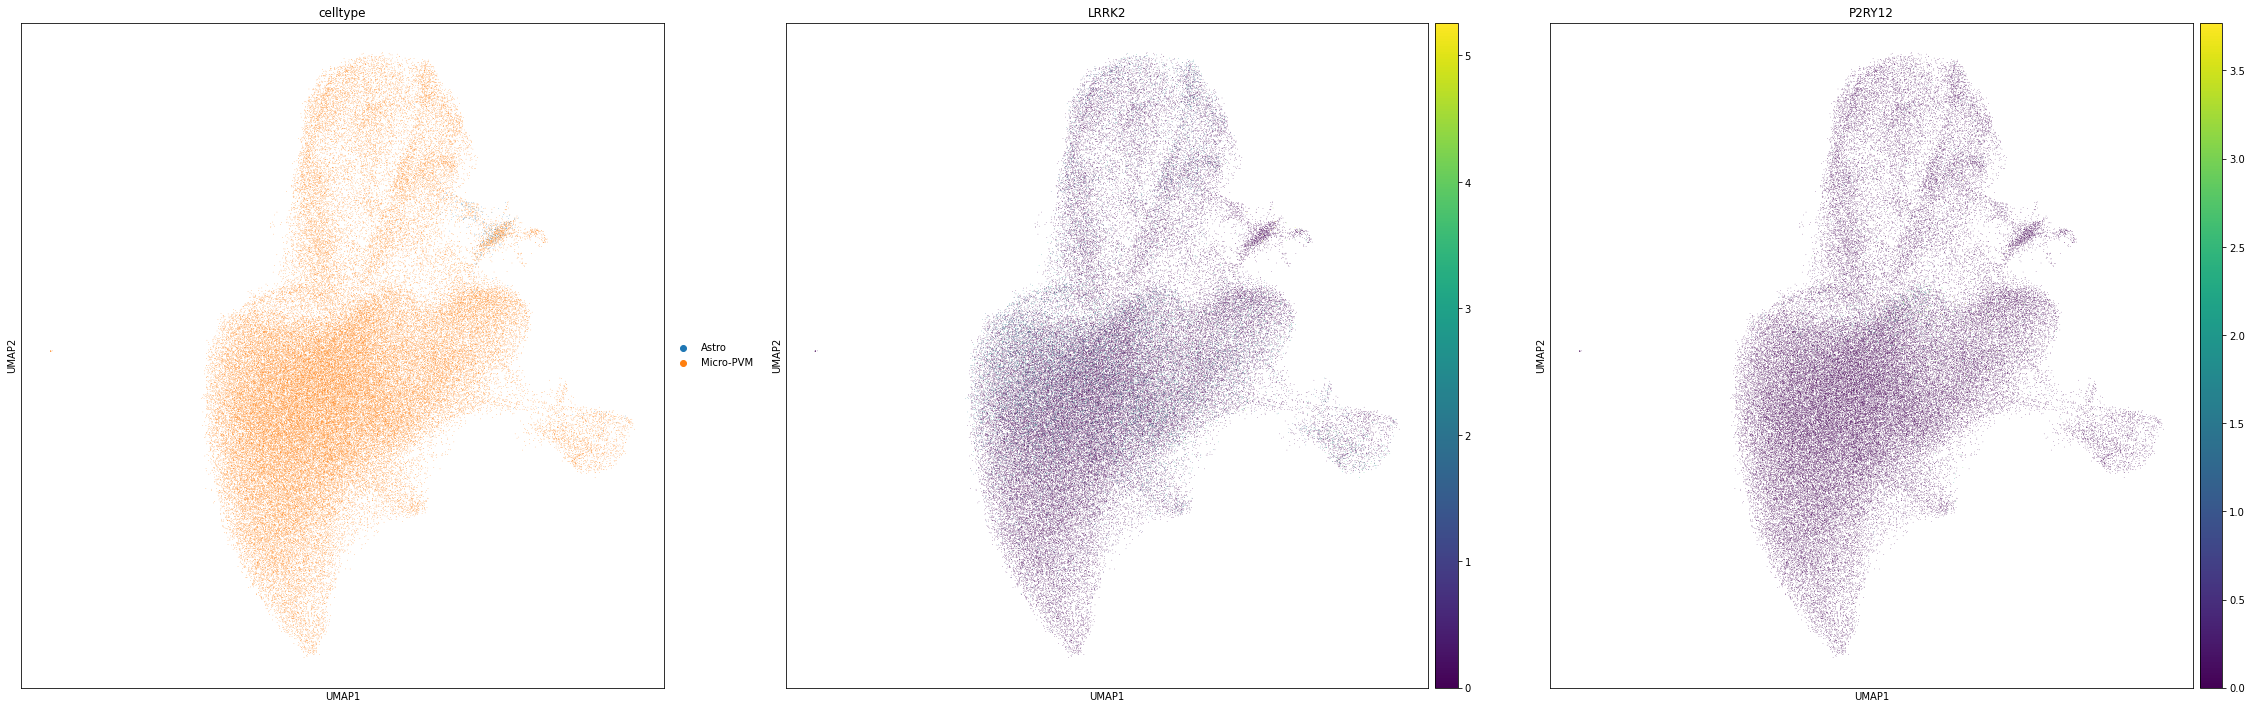

In [19]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['celltype', 'LRRK2', 'P2RY12'])

#### As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

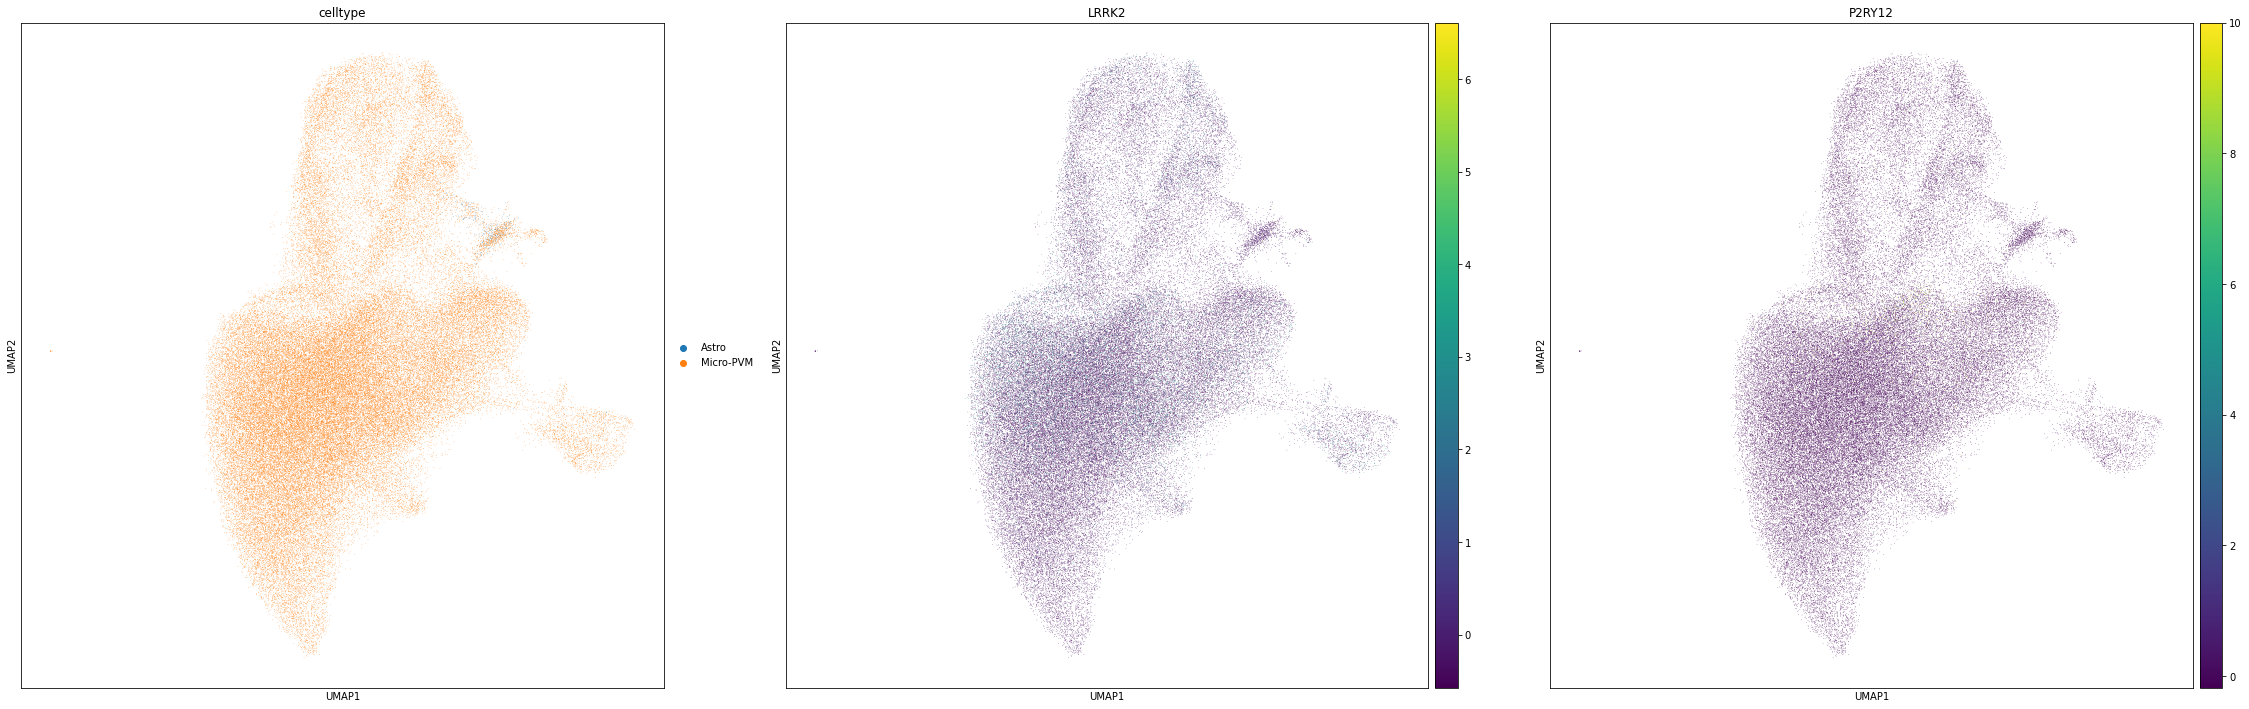

In [20]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['celltype', 'LRRK2', 'P2RY12'], use_raw=False)

### Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [21]:
sc.tl.leiden(adata, resolution=0.5)

#### Plot the clusters

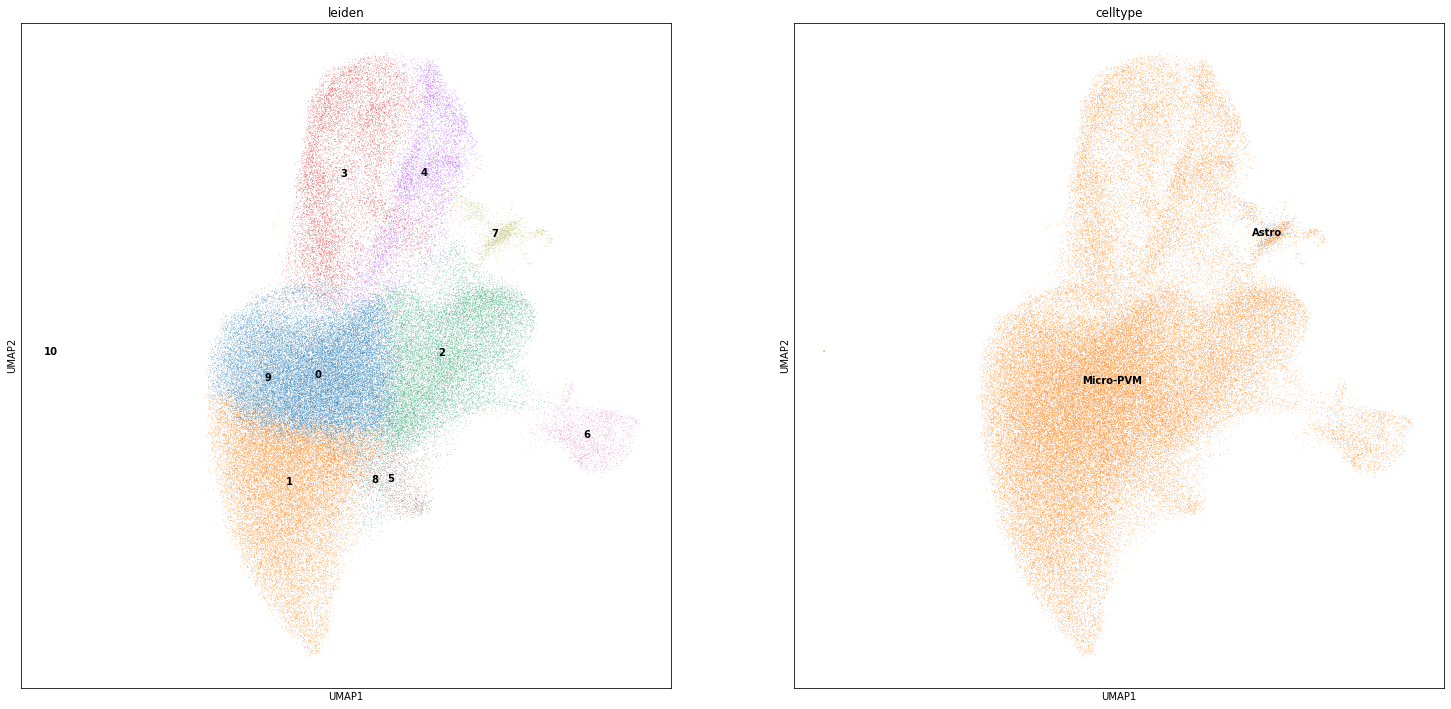

In [22]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['leiden', 'celltype'], legend_loc='on data')

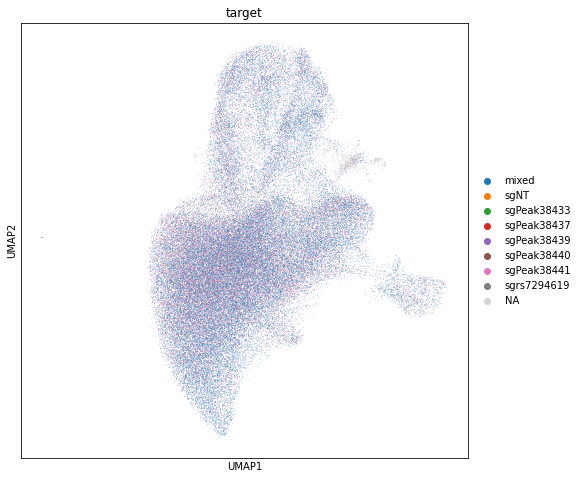

In [23]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color=['target'])

### Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.



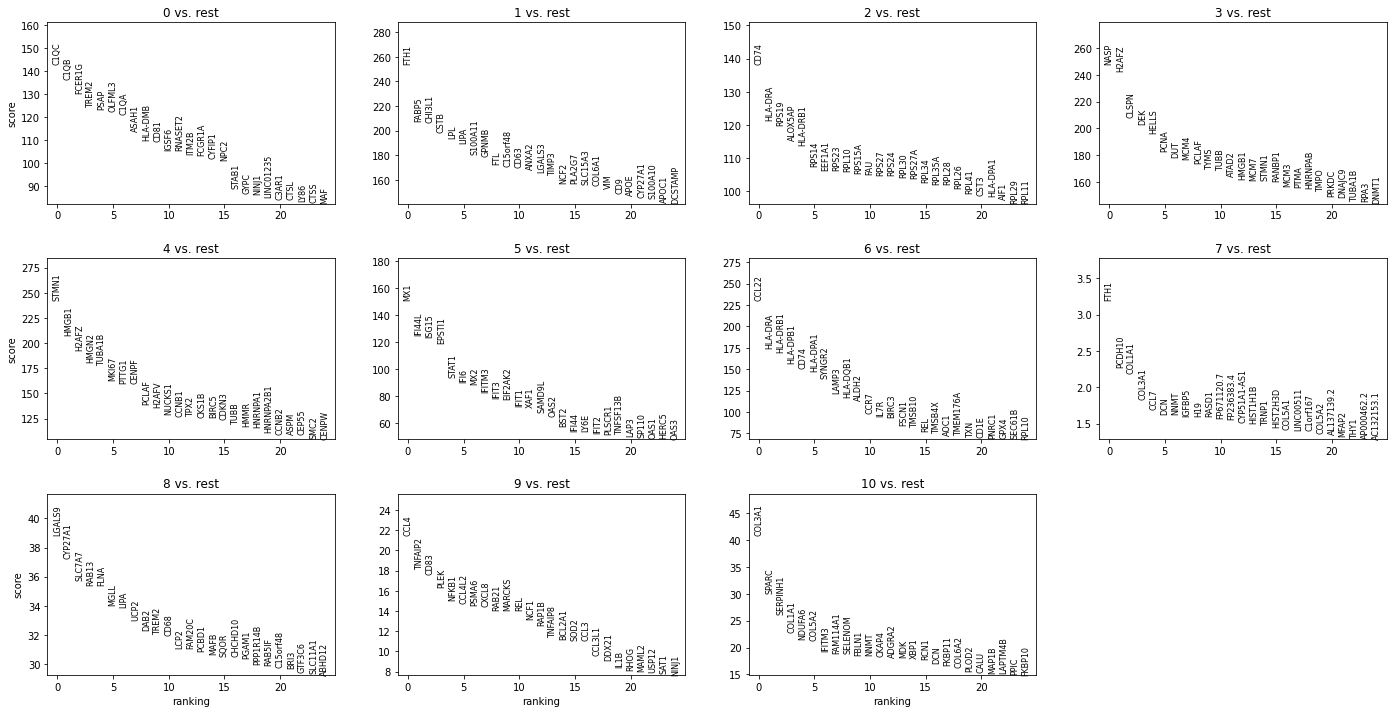

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

#### The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

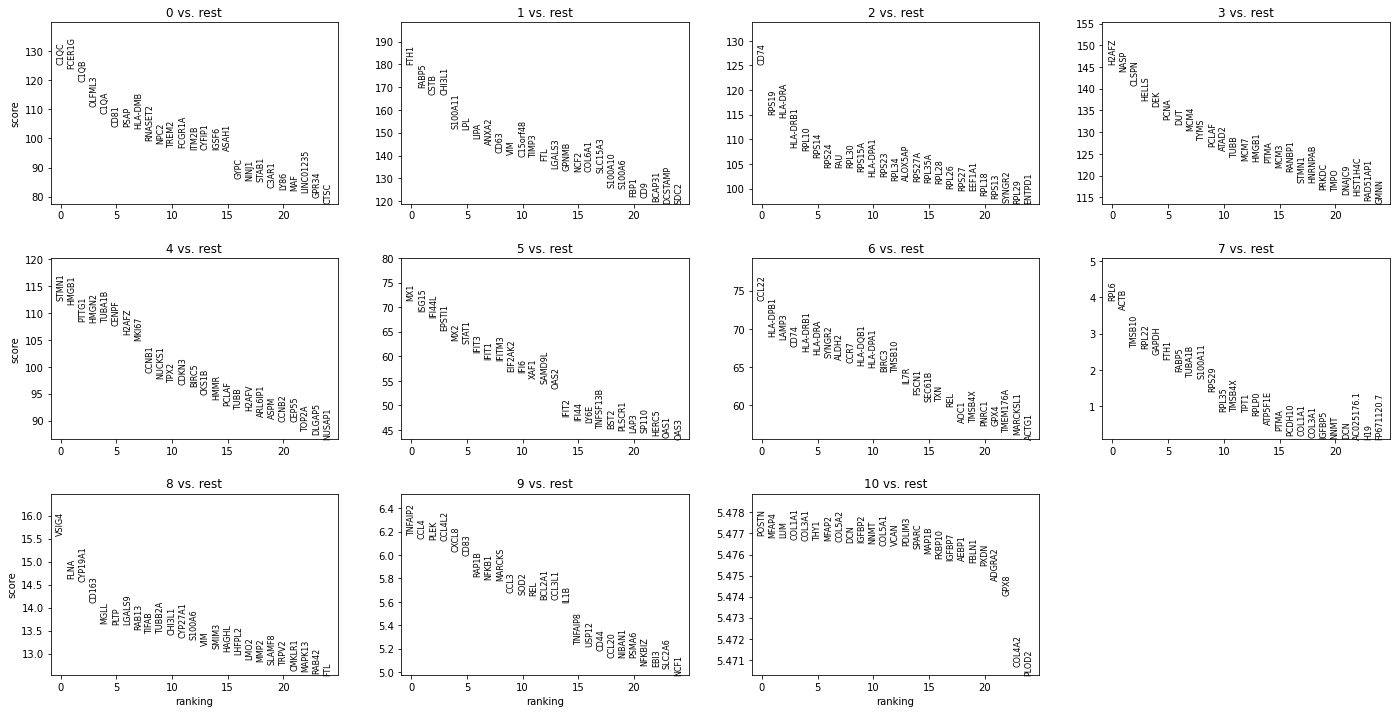

In [25]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

#### Now that we annotated the cell types, let us visualize the marker genes.

In [26]:
# manually add marker genes for Microglia and Astrocytes; plus LRRK2
marker_genes = ["TGFBR1", "DOCK8", "CD74", "CSF1R", "MS4A6A", "PLXDC2", 
                "P2RY12", "ITGAM", "CX3CR1", "CCL4", "CCL3", "CTSS", 
                "TYROBP", "CD83", "RGS10", "AIF1", 'LRRK2',
                "SLC1A3", "GFAP", "APOE", "SLC1A2", "SLC14A1", 
                "CPE", "CLU", "ALDOC", "FAM19A1", "AQP4", "GJB6"]
print(len(marker_genes))
marker_genes = list(set(marker_genes) & set(adata.var.index))
print(len(marker_genes))
print(marker_genes)

28
27
['LRRK2', 'CTSS', 'CLU', 'CSF1R', 'APOE', 'CCL3', 'TYROBP', 'DOCK8', 'GJB6', 'CPE', 'GFAP', 'P2RY12', 'CD74', 'SLC1A3', 'SLC1A2', 'CD83', 'AIF1', 'TGFBR1', 'CX3CR1', 'PLXDC2', 'MS4A6A', 'SLC14A1', 'CCL4', 'AQP4', 'RGS10', 'ALDOC', 'ITGAM']


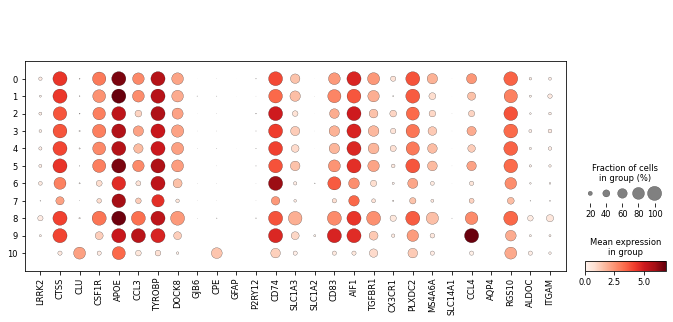

In [27]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

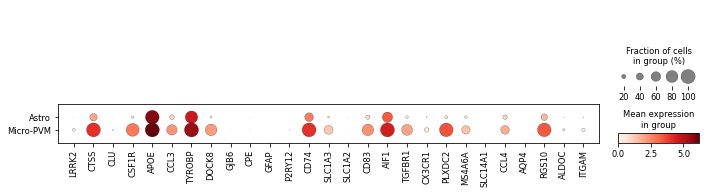

In [28]:
sc.pl.dotplot(adata, marker_genes, groupby='celltype')

In [29]:
adata

AnnData object with n_obs × n_vars = 94109 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'leiden', 'leiden_colors', 'target_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
print(adata.obs['celltype'].value_counts())

Micro-PVM    93748
Astro          361
Name: celltype, dtype: int64


In [31]:
print(adata.obs['leiden'].value_counts())

0     30713
1     23566
2     16672
3     10971
4      6140
5      1973
6      1888
7      1763
8       400
9        13
10       10
Name: leiden, dtype: int64


#### save the modified anndata object

In [32]:
adata.write(results_file)

#### save a smaller version of the anndata object

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in adata.raw.

In [33]:
adata.raw.to_adata().write(results_light_file)

In [34]:
!date

Wed Feb  2 16:14:09 EST 2022
